#       E-commerce Data Analysis Using SQL and Python EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Viraj@123",
                             database = "ecommerce")

cur = db.cursor()

## List of unique cities where customers are located :-

In [3]:
query = """ SELECT DISTINCT customer_city FROM customers """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head(11)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


## Count of orders placed in 2017 :-

In [4]:
query = """ SELECT COUNT(order_id) FROM orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017 are",data[0][0]

('total orders placed in 2017 are', 90202)

## Total sales per category :-

In [5]:
query = """
SELECT 
    UPPER (p.product_category),
    ROUND(SUM(oi.price), 2) AS total_sales
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_category
ORDER BY total_sales DESC
"""
cur.execute(query)
data = cur.fetchall()


df = pd.DataFrame(data, columns=['product_category', 'total_sales'])
df.head(11)


,product_category,total_sales
0,HEALTH BEAUTY,5034725.36
1,WATCHES PRESENT,4820022.71
2,BED TABLE BATH,4147954.72
3,SPORT LEISURE,3952195.88
4,COMPUTER ACCESSORIES,3647817.27
5,FURNITURE DECORATION,2919049.97
6,COOL STUFF,2541163.41
7,HOUSEWARES,2528994.64
8,AUTOMOTIVE,2370880.44
9,GARDEN TOOLS,1941025.85


## Percentage of orders that were paid in installments :-

In [6]:
query = """
SELECT 
    ROUND(
        100 * SUM(CASE WHEN payment_installments > 1 THEN 1 ELSE 0 END) / COUNT(DISTINCT order_id),
        2
    ) AS percentage_in_installments
FROM payments
"""
cur.execute(query)
data = cur.fetchall()
"Percentage of orders paid in installments:", data[0][0], "%"


('Percentage of orders paid in installments:', Decimal('103.25'), '%')

## Count of customers from each state :-

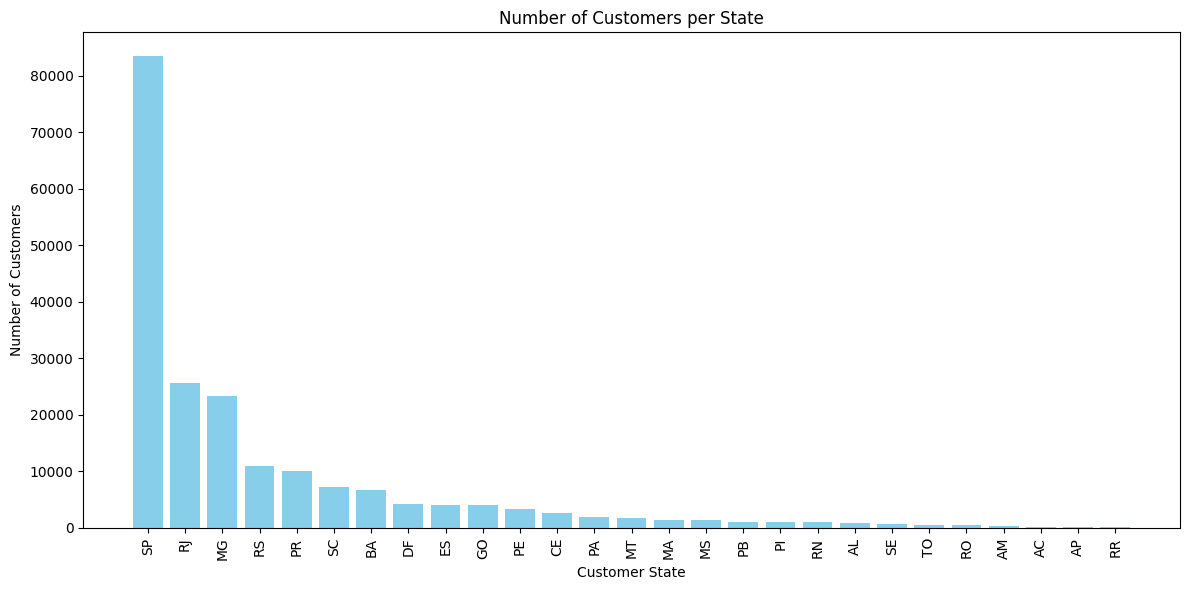

In [7]:
query = """
SELECT 
    customer_state, 
    COUNT(*) AS customer_count
FROM customers
GROUP BY customer_state
ORDER BY customer_count DESC
"""
cur.execute(query)
data = cur.fetchall()

import pandas as pd
df = pd.DataFrame(data, columns=['customer_state', 'customer_count'])
plt.figure(figsize=(12, 6))  
plt.bar(df['customer_state'], df['customer_count'], color='skyblue')
plt.xticks(rotation=90)  
plt.xlabel('Customer State')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per State')
plt.tight_layout()  
plt.show()

## Number of orders per month in 2018 :-

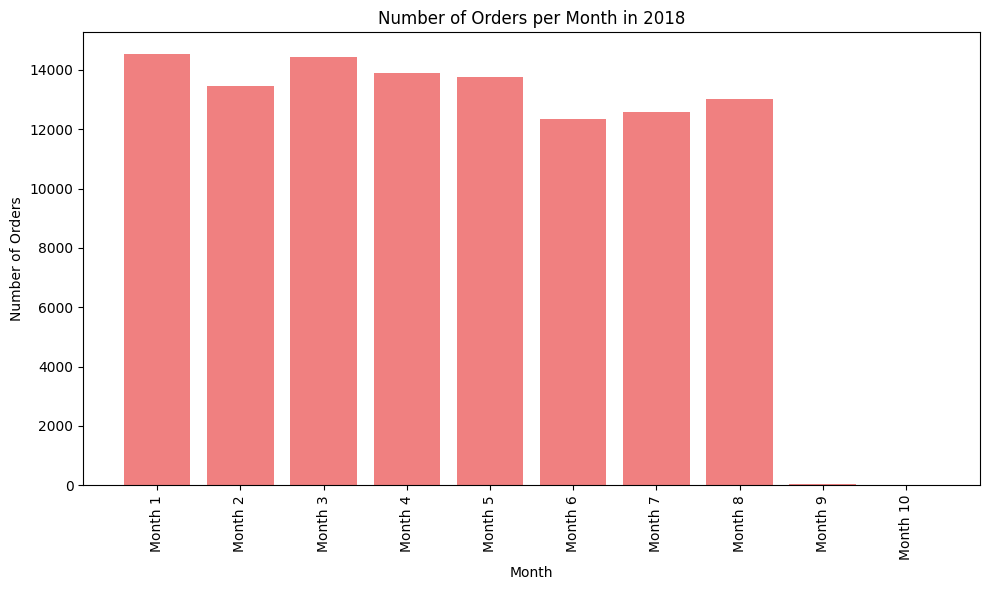

In [8]:
query = """
SELECT 
    YEAR(order_purchase_timestamp) AS order_year, 
    MONTH(order_purchase_timestamp) AS order_month, 
    COUNT(order_id) AS order_count
FROM orders
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY order_year, order_month
ORDER BY order_month
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=['order_year', 'order_month', 'order_count'])
plt.figure(figsize=(10, 6))
plt.bar(df['order_month'], df['order_count'], color='lightcoral')
plt.xticks(df['order_month'], labels=[f'Month {i}' for i in df['order_month']], rotation=90)
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.title('Number of Orders per Month in 2018')
plt.tight_layout()
plt.show()


## Average number of products per order, grouped by customer city :-

In [4]:
query = """
WITH count_per_order AS (
    SELECT 
        orders.order_id, 
        orders.customer_id, 
        COUNT(order_items.order_id) AS oc
    FROM orders 
    JOIN order_items ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)

SELECT 
    customers.customer_city, 
    ROUND(AVG(count_per_order.oc), 2) AS average_orders
FROM customers 
JOIN count_per_order ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city 
ORDER BY average_orders DESC
"""

cur.execute(query)
data = cur.fetchall()

import pandas as pd
df = pd.DataFrame(data, columns=["customer city", "average products/order"])
df.head(11)


,customer city,average products/order
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
5,cidelandia,16.00
6,curralinho,16.00
7,picarra,16.00
8,morro de sao paulo,16.00
9,teixeira soares,16.00


## Top 7 Product Categories by Revenue Contribution :-

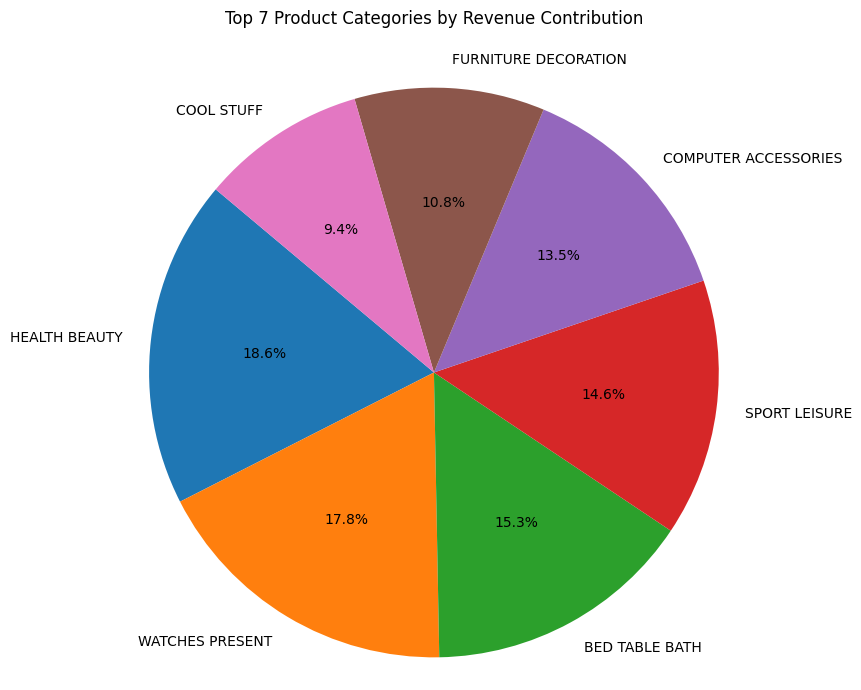

In [7]:
query = """
SELECT 
    UPPER(p.product_category) AS category,
    ROUND(SUM(oi.price) * 100 / (SELECT SUM(price) FROM order_items), 2) AS revenue_percentage
FROM products p
JOIN order_items oi ON p.product_id = oi.product_id
GROUP BY category
ORDER BY revenue_percentage DESC
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "Revenue Percentage"])

top7 = df.head(7)
plt.figure(figsize=(9, 7))
plt.pie(
    top7['Revenue Percentage'], 
    labels=top7['Category'], 
    autopct='%1.1f%%', 
    startangle=140
)

plt.title('Top 7 Product Categories by Revenue Contribution', pad=30)  
plt.axis('equal')  
plt.tight_layout()  
plt.subplots_adjust(top=0.9)  
plt.show()



 ## Correlation between product price and the number of times a product has been purchased :-

In [6]:
cur = db.cursor()
query = """
SELECT products.product_category, 
       COUNT(order_items.product_id),
       ROUND(AVG(order_items.price), 2)
FROM products 
JOIN order_items ON products.product_id = order_items.product_id
GROUP BY products.product_category
"""
import numpy as np
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "order_count", "price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1, arr2])
print("The correlation is", a[0][-1])

The correlation is -0.10631514167157562


## Total revenue generated by each seller, and rank by revenue :-

In [17]:
query = """ SELECT *, 
       DENSE_RANK() OVER (ORDER BY revenue DESC) AS rn 
FROM (
    SELECT order_items.seller_id, 
           ROUND(SUM(payments.payment_value),2) AS revenue
    FROM order_items 
    JOIN payments ON order_items.order_id = payments.order_id
    GROUP BY order_items.seller_id
) AS a
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df.head(11)


,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,2028667.63,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,1232888.16,2
2,4a3ca9315b744ce9f8e9374361493884,1204981.08,3
3,1f50f920176fa81dab994f9023523100,1161013.68,4
4,53243585a1d6dc2643021fd1853d8905,1139612.32,5
5,da8622b14eb17ae2831f4ac5b9dab84a,1088877.28,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,1056664.48,7
7,955fee9216a65b617aa5c0531780ce60,945289.20,8
8,fa1c13f2614d7b5c4749cbc52fecda94,826052.92,9
9,7e93a43ef30c4f03f38b393420bc753a,740536.84,10


## Moving average of order values for each customer over their order history :-

In [15]:
query = """SELECT 
    customer_id, 
    order_purchase_timestamp, 
    payment,
    AVG(payment) OVER (
        PARTITION BY customer_id 
        ORDER BY order_purchase_timestamp 
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ) AS mov_avg
FROM (
    SELECT 
        orders.customer_id, 
        orders.order_purchase_timestamp, 
        payments.payment_value AS payment
    FROM payments 
    JOIN orders ON payments.order_id = orders.order_id
) AS a;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Customer ID", "Order Date", "Payment", "Moving Average"])
df


,Customer ID,Order Date,Payment,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


## Cumulative sales per month for each year :-

In [6]:
query = """
SELECT 
  years, 
  months, 
  payment, 
  SUM(payment) OVER(ORDER BY years, months) cumulative_sales
FROM (
  SELECT 
    YEAR(orders.order_purchase_timestamp) AS years,
    MONTH(orders.order_purchase_timestamp) AS months,
    ROUND(SUM(payments.payment_value), 2) AS payment
  FROM orders 
  JOIN payments ON orders.order_id = payments.order_id
  GROUP BY years, months 
  ORDER BY years, months
) AS a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Year", "Month", "Monthly Sales", "Cumulative Sales"])
df

,Year,Month,Monthly Sales,Cumulative Sales
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


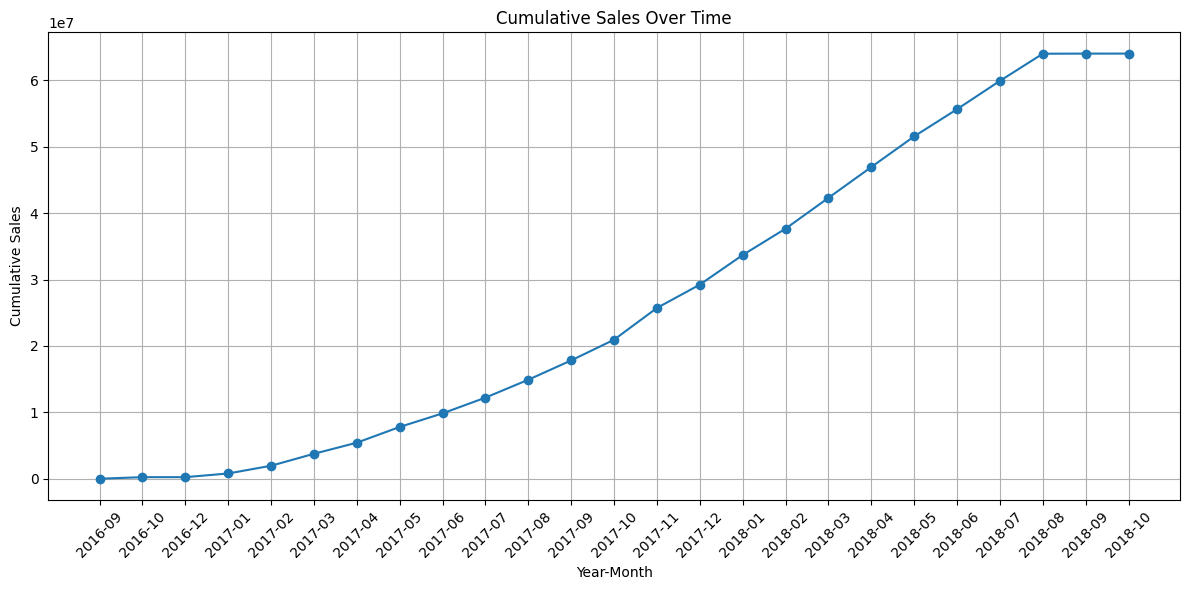

In [7]:
df["Month"] = df["Month"].astype(int).astype(str).str.zfill(2)
df["Year-Month"] = df["Year"].astype(str) + "-" + df["Month"]

plt.figure(figsize=(12,6))
plt.plot(df["Year-Month"], df["Cumulative Sales"], marker='o')
plt.title("Cumulative Sales Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Cumulative Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Year-Over-Year(YoY) growth rate of total sales :-

In [13]:
query = """
WITH a AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        ROUND(SUM(payments.payment_value), 2) AS payment
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years 
    ORDER BY years
)
SELECT 
    years, 
    ((payment - LAG(payment, 1) OVER (ORDER BY years)) / 
      LAG(payment, 1) OVER (ORDER BY years)) * 100 AS YoY_growth
FROM a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "YoY % growth"])
df

,years,YoY % growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


## Retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [17]:
query = """
WITH a AS (
    SELECT 
        customers.customer_id,
        MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),
b AS (
    SELECT 
        a.customer_id, 
        COUNT(DISTINCT orders.order_purchase_timestamp) AS next_order
    FROM a 
    JOIN orders ON orders.customer_id = a.customer_id
        AND orders.order_purchase_timestamp > first_order
        AND orders.order_purchase_timestamp < DATE_ADD(first_order, INTERVAL 6 MONTH)
    GROUP BY a.customer_id
)
SELECT 
    100 * (COUNT(DISTINCT a.customer_id) / COUNT(DISTINCT b.customer_id)) 
FROM a 
LEFT JOIN b ON a.customer_id = b.customer_id;
"""

cur.execute(query)
data = cur.fetchall()
data

[(None,)]

Note: The calculated retention rate is 0% because the dataset does not contain any repeat customers.

## Top 3 customers who spent the most money in each year:-

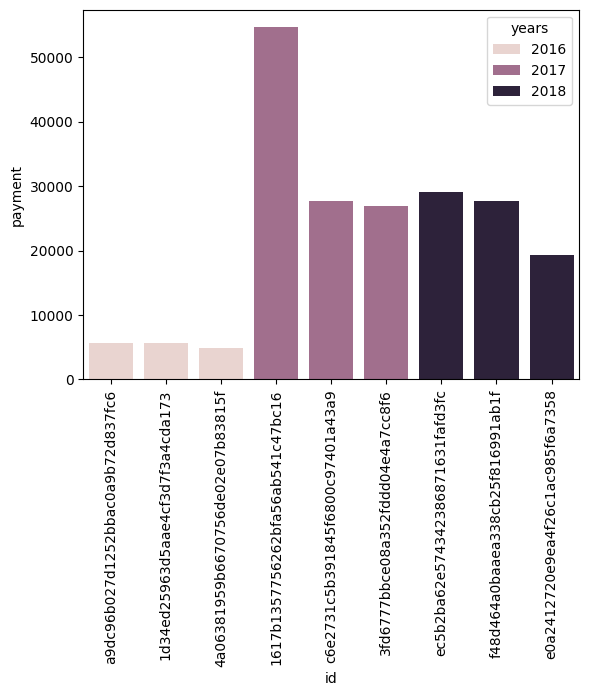

In [18]:
query = """
SELECT years, customer_id, payment, d_rank
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        orders.customer_id,
        SUM(payments.payment_value) AS payment,
        DENSE_RANK() OVER (PARTITION BY YEAR(orders.order_purchase_timestamp)
                           ORDER BY SUM(payments.payment_value) DESC) AS d_rank
    FROM orders
    JOIN payments 
        ON payments.order_id = orders.order_id
    GROUP BY YEAR(orders.order_purchase_timestamp), orders.customer_id
) AS a
WHERE d_rank <= 3;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["years", "id", "payment", "rank"])
sns.barplot(x="id", y="payment", data=df, hue="years")
plt.xticks(rotation=90)
plt.show()


## Project Conclusion :-
### This is a comprehensive analysis of an e-commerce dataset, focusing on customer behavior, sales performance, and revenue trends. Key insights were derived using SQL queries and Python visualizations to support data-driven business strategies.

### The analysis included metrics such as total revenue per seller, customer purchase patterns, category-level performance, and year-over-year growth. Notable findings include identification of top-performing sellers and customers by year, limited customer retention within six months, and a weak correlation between product price and purchase frequency. Moving averages and cumulative monthly sales helped track trends and fluctuations over time.
